This notebook showcases plotting data from the Statistics Finland PAAVO data set.

In [3]:
from itertools import chain
import pandas as pd
import data_transforms
import from_r_gen
import viz
import similarity
import map_fi_plot
import matplotlib.pyplot as plt
%matplotlib inline
import os
os.chdir('/Users/tjpajala/PycharmProjects/paavo')
os.getcwd()

'/Users/tjpajala/PycharmProjects/paavo'

In [4]:
data = from_r_gen.load_r_data('paavo_counts.csv')
data2 = from_r_gen.load_r_data('paavo_shares.csv')

#combine nominal and share vars
data = data.loc[:, list(chain.from_iterable([['pono', 'pono.level', 'vuosi', 'nimi'], data_transforms.NOMINAL_VARS]))]
data2 = data2.loc[:, list(chain.from_iterable([['pono', 'vuosi', 'nimi'], data_transforms.SHARES_VARS]))]


cols_to_use = data2.columns.difference(data.columns)
data = pd.merge(data, data2[cols_to_use], left_index=True, right_index=True, how='outer')
data = data.reindex()

data.loc[data['pono.level'] == 5, 'pono'] = [format(x, '05d') for x in data.loc[data['pono.level'] == 5, 'pono']]
data.loc[data['pono.level'] == 3, 'pono'] = [format(x*100, '05d') for x in data.loc[data['pono.level'] == 3, 'pono']]
data.loc[data['pono.level'] == 2, 'pono'] = [format(x*100, '05d') for x in data.loc[data['pono.level'] == 2, 'pono']]


to_format = ['he_kika', 'tr_mtu', 'ra_as_kpa', 'hr_pi_tul', 'hr_ke_tul', 'hr_hy_tul',
             'pt_tyoll', 'pt_tyott', 'pt_tyovu', 'pt_0_14', 'pt_opisk', 'pt_elakel', 'hr_ovy',
             'tr_pi_tul', 'tr_ke_tul', 'tr_hy_tul', 'te_nuor', 'te_eil_np', 'te_laps', 'te_aik',
             'te_elak', 'te_omis_as', 'te_vuok_as', 'te_takk', 'te_as_valj']
for c in to_format:
    data[c] = [float(str(x).replace(",", ".")) for x in data[c]]


data.fillna(0, inplace=True)

#select only one year
data = data.loc[data['vuosi'] == 2018, :]

/Users/tjpajala/miniconda3/envs/some_env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2901: DtypeWarning: Columns (11,40,41,62,63) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/Users/tjpajala/miniconda3/envs/some_env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2901: DtypeWarning: Columns (9,18,19,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/Users/tjpajala/miniconda3/envs/some_env/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


Ok, data has been loaded.

Let's do an exploration of PCA variancee explanation, to see how many dimensions we might want to use.

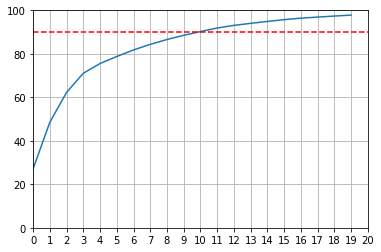

In [5]:
X, y, target_names = viz.get_pca_data(data, 2018, 5)
target_names.index = range(len(target_names))
viz.exploratory_pca(X, 20)

Well, based on the plot it looks like we might need quite a few dimensions to capture the variance! I was expecting the data to reduce to fewer dimensions quite nicely, but perhaps not. Let's plot a two-factor PCA to see what it looks like:

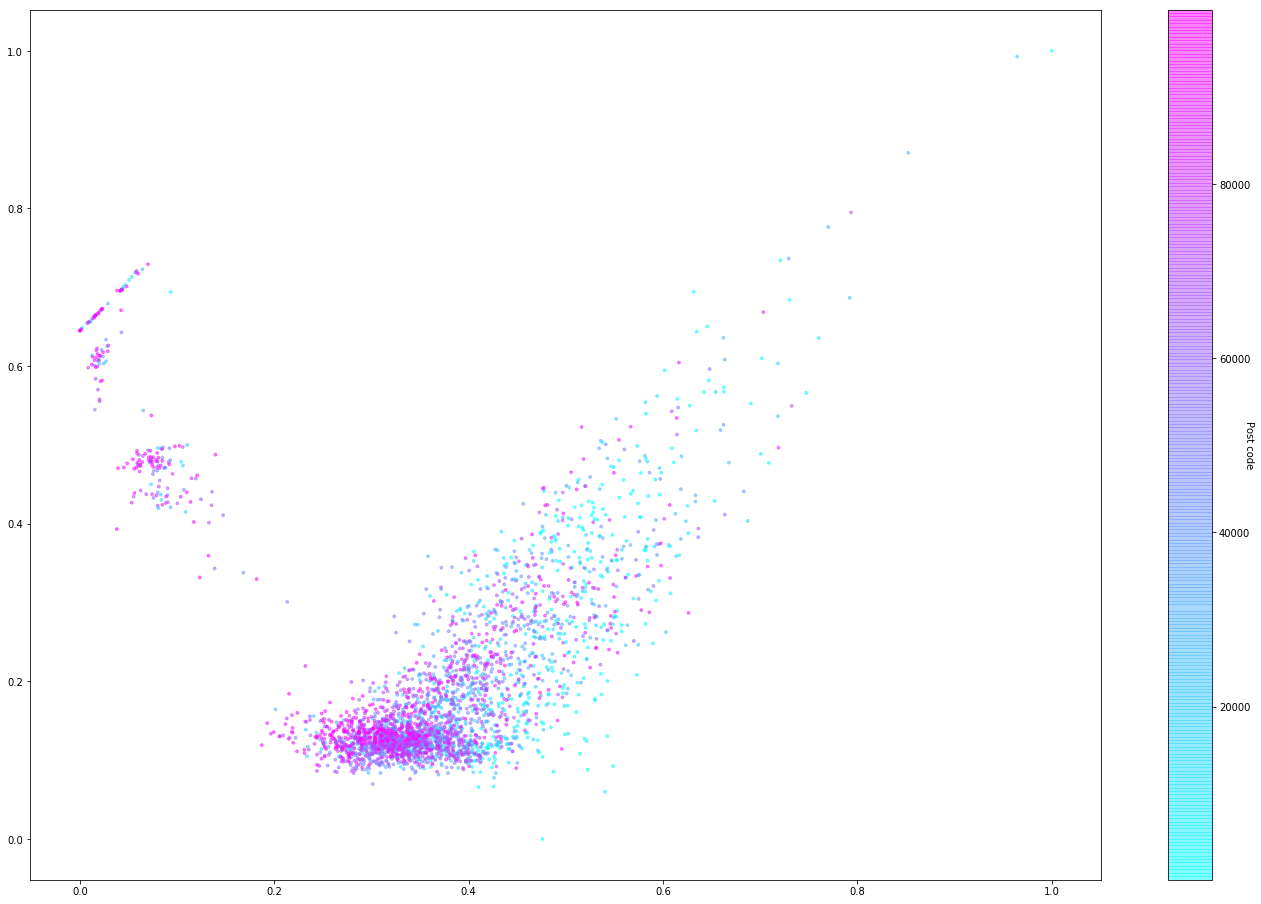

In [6]:
X_pca, pipe = viz.do_pca(X, 2)
viz.pca_plot(X_pca, target_names, y.ravel())

Yeah, it really looks like there is some structure in the data that is not captured in the two dimensions.

Now, an interesting way of looking at the results is to plot them on the map of postcodes. We will classify each area according to the factor that has the highest load, and plot this variable on the map. If our PCA is good at compressing differences between cities and the countryside into the loadings, this should be visible on the map.

Let's start with two dimensions.

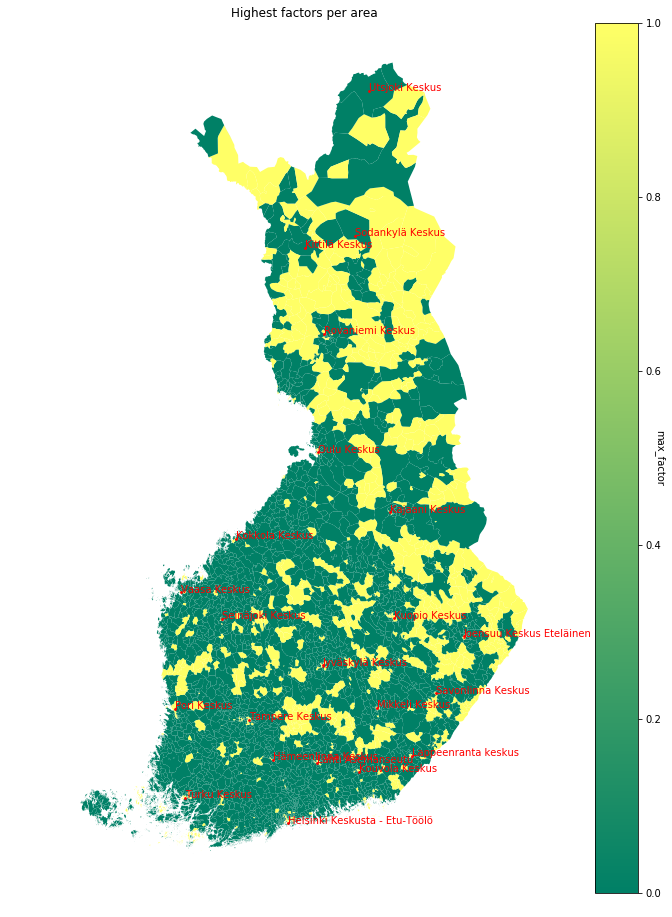

In [7]:
X_pca, pipe = viz.do_pca(X, 2)
data_l2 = data.loc[data['pono.level'] == 5, :].assign(max_factor=pd.DataFrame(X_pca.argmax(axis=1)))
map_fi_plot.map_fi_postinumero(data_l2, "Highest factors per area", color_var='max_factor')


It's not that great, is it. All the cities have the same max loading factor, but there are a ton of other areas with the same property, too. I'm guessing we could do better.

Let's try with five dimensions.

In [6]:
X_pca, pipe = viz.do_pca(X, 5)
data_l5 = data.loc[data['pono.level'] == 5, :].assign(max_factor=pd.DataFrame(X_pca.argmax(axis=1)))
map_fi_plot.map_fi_postinumero(data_l5, "Highest factors per area", color_var='max_factor')

NameError: name 'X' is not defined

Excellent! This looks much better already! It seems that five dimensions are enough to capture the differences between cities, their surrounding boroughs, and the countryside.

The functions also allow for printing and plotting postcode areas that are "most similar" to a given postcode area. For example, which 15 areas are most similar to Otaniemi?

In [7]:
d = similarity.pairwise_distances(X_pca, X_pca, 'euclidean')
names = similarity.get_n_most_similar_with_name("Otaniemi", d, target_names, 15)
print(names)

NameError: name 'X_pca' is not defined

In [8]:
map_fi_plot.map_with_highlights_names(data_l5, "15 areas most similar to Otaniemi", 'Otaniemi', names)


NameError: name 'data_l5' is not defined

All the areas above are at leas plausible on their face: each postcode area is somewhat close to a University.

Let's try the same thing with a different origin area: Kallio.

In [9]:
names = similarity.get_n_most_similar_with_name("Kallio", d, target_names, 15)
print(names)

NameError: name 'd' is not defined

In [10]:
map_fi_plot.map_with_highlights_names(data_l5, "15 areas most similar to Kallio", 'Kallio', names)

NameError: name 'data_l5' is not defined

This result is maybe a little bit more surprising. We get areas close in geography, like Sörnäinen and Alppila, and also some central areas of other cities. But there is also Kamppi (dense city but richer) and Kirkonkylä from Vantaa. Lastly, a close match is the factory district of Pitäjänmäki, no idea why.